<a href="https://colab.research.google.com/github/rkj26/textClassifier/blob/master/classifierV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Run this cell when running in Google Colab
%%capture
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
!pip install selenium

In [0]:
import re
from string import ascii_uppercase
import pandas as pd
import numpy as np
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import string

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from random import randint
import datetime

In [0]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

**Adding more elements to the vessels array**

In [0]:
ports = []
vessels_new = []
companies = []
dates = []

In [0]:
temp = 'https://directories.lloydslist.com/port-browse-name/searchid/0/searchchar/'  #This part is link of the search query that is constant so I decided to hardcode it
wd = webdriver.Chrome('chromedriver',options=chrome_options)
for c in ascii_uppercase:
  i = 1
  url = temp + c # Go over all the letters in alphabets and store the ports
  while(True):              # As each page has different number of results, using try and except to break the loop when there are no results left to store.
    try:
      if i == 1:
        wd.get(url=url)
        souplevel = BeautifulSoup(wd.page_source, 'lxml')
      else:
        button = wd.find_element_by_link_text(str(i))
        button.click()
        souplevel = BeautifulSoup(wd.page_source, 'lxml')

      for child in souplevel.find_all('a', href=re.compile('port-browse-listing/portid')): #All ports are stored using this template therefore used regular expression to find all <a href = ''></a> tags and stored their text. 
        if child.text != 'Learn More':
          ports.append(child.text) 
    
      i+=1
    except:
      break

In [0]:
wd = webdriver.Chrome('chromedriver',options=chrome_options)
wd.get('https://www.fleetmon.com/vessels/')
noPages = 300
for page in range(noPages):
  soup = BeautifulSoup(wd.page_source, 'lxml')
  temp = []
  for child in soup.find_all('a', href=re.compile('/vessels/')):
    temp.append(child.text)
  vessels_new = vessels_new +temp[2:22]
  # button = WebDriverWait(wd, 20).until(EC.presence_of_element_located((By.ID, 'vesselsearch_table_next')))
  # button.click()
  element = wd.find_element_by_id('vesselsearch_table_next')
  wd.execute_script("arguments[0].click();", element)


In [0]:
NO_OF_PAGES=25 #Only 25 pages to view therefore hard coded it.
wd = webdriver.Chrome('chromedriver',options=chrome_options)
url = 'https://www.marinetraffic.com/en/data/?asset_type=vessels&columns=flag,shipname,photo,recognized_next_port,reported_eta,reported_destination,current_port,imo,ship_type,show_on_live_map,time_of_latest_position,lat_of_latest_position,lon_of_latest_position'
wd.get(url=url)
for i in range(NO_OF_PAGES):
  button = WebDriverWait(wd, 20).until(EC.presence_of_element_located((By.XPATH, '//*[@id="reporting_ag_grid"]/div/div[2]/div[3]/div/div/div/div/div[3]/button[2]')))
  if i!=0:
    button.click()
  soup = BeautifulSoup(wd.page_source, 'lxml')
  for element in soup.find_all('a', href=re.compile('/en/ais/details/ships/')): #Similar thought as the for port web scrapper.
    vessels_new.append(element.text)

In [0]:
url = 'https://opencorporates.com/registers'
wd = webdriver.Chrome('chromedriver',options=chrome_options)
wd.get(url)
soup = BeautifulSoup(wd.page_source, 'lxml')
numberOfRegistries = int(soup.find(id='DataTables_Table_0_info').text.split(' ')[-2]) #Finding out the number of registries
for i in range(numberOfRegistries):
  xpath = '//*[@id="DataTables_Table_0"]/tbody/tr['+str(i+1)+']/td[3]/a' #Every row of the table and third column which is a clickable link to the companies.
  companiesLink = WebDriverWait(wd, 20).until(EC.presence_of_element_located((By.XPATH, xpath)))
  companiesLink.click()
  lookup = str(wd.current_url)[26:]+'/'  #Lookup for the directory link which is used for every company in the registry

  for j in range(3): 
    if j != 0:
      nextPath = '//*[@id="results"]/div/div[1]/ul/li[8]/a'  #XPath for the next button
      nextButton = wd.find_element_by_xpath(nextPath)
      nextButton.click()
        
    subSoup = BeautifulSoup(wd.page_source, 'lxml')
    for k in subSoup.find_all('a', href=re.compile(lookup)):
      companies.append(k.text)
  wd.get(url)

In [0]:
ports = np.array(ports)
vessels = np.array(vessels_new)
companies = np.array(companies)

In [0]:
def dateGenerator():
  i = randint(0,4)
  dd, mm, yyyy = randomGenerator()
  correct = check_date(yyyy, mm, dd)
  if correct:
    date = datetime.datetime(yyyy, mm, dd)
    if i==0:
      date = "{0:0=2d}".format(dd)+'/'+"{0:0=2d}".format(mm)+'/'+str(yyyy)
    elif i==1:
      date = "{0:0=2d}".format(mm)+'/'+"{0:0=2d}".format(dd)+'/'+str(yyyy)
    elif i==2:
      date = str(yyyy)+'/'+"{0:0=2d}".format(mm)+'/'+"{0:0=2d}".format(dd)
    elif i==3:
      date = date.strftime("%b %d %Y")
    elif i==4:
      date = date.strftime("%B %d %Y")
    return date
  else:
    return dateGenerator()

In [0]:
def randomGenerator():
  dd = randint(1,31)
  mm = randint(1,12)
  yyyy = randint(1970, 2020)
  return dd, mm, yyyy

In [0]:
def check_date(year, month, day):
    correctDate = None
    try:
        newDate = datetime.datetime(year, month, day)
        correctDate = True
    except ValueError:
        correctDate = False
    return correctDate

In [0]:
for i in range(6500):
  dates.append(dateGenerator())

In [0]:
df = pd.DataFrame(columns=['Text', 'Target'])
np.random.shuffle(ports)
np.random.shuffle(companies)
np.random.shuffle(vessels)

**Creating a shuffled dataset with 26000 entries. Each class has 6500 samples**

In [0]:
i = 0 
for port in ports:
  if i <6500:
    port = port.lower()
    #df = df.append({'Text':port, 'Target': 0}, ignore_index=True)
    port = port.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))
    port = ' '.join(port.split())
    df = df.append({'Text':port, 'Target': 0}, ignore_index=True)
    i += 1
  else:
    i = 0
    break

for vessel in vessels:
  if i <6500:
    vessel = vessel.lower()
    #df = df.append({'Text':vessel, 'Target': 1}, ignore_index=True)
    vessel = vessel.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))
    vessel = ' '.join(vessel.split())
    df = df.append({'Text':vessel, 'Target': 1}, ignore_index=True)
    i += 1
  else:
    i = 0
    break

i = 0
for company in companies:
  if i<6500:
    company = str(company)
    company = company.lower()
    #df = df.append({'Text':company, 'Target': 2}, ignore_index=True)
    company = company.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))
    company = ' '.join(company.split())
    df = df.append({'Text':company, 'Target': 2}, ignore_index=True)
    i+=1
  else:
    i = 0
    break


for date in dates:
  if i<6500:
    date = str(date)
    date = date.lower()
    date = date.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))
    #df = df.append({'Text':date, 'Target': 3}, ignore_index=True)
    date = ' '.join(date.split())
    df = df.append({'Text':date, 'Target': 3}, ignore_index=True)
    i+=1
  else:
    i = 0
    break


In [0]:
#df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)

In [0]:
X = df['Text'].values
y = df['Target'].values

**Splitting dataset to Train: 75%, Validate: 15% Test: 10%**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state=42,shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val,test_size = 0.4, random_state=42,shuffle=True, stratify= y_val)

In [0]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')
y_val = y_val.astype('int')

**Pipeline for the preprocessing using CountVectorizer and TF-IDF and using an stacked model of Logistic Regression and RandomForest (no hyper-parameter tuning)**

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from mlxtend.classifier import StackingClassifier
lr = LogisticRegression()
rf = RandomForestClassifier()
gradB = GradientBoostingClassifier

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', StackingClassifier(classifiers=[LogisticRegression(), RandomForestClassifier()], 
                          meta_classifier=GradientBoostingClassifier()))])

In [0]:
text_clf.fit(X_train, y_train)

**Cross Validation using 5-folds stratified**

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [0]:
cv_score = cross_val_score(text_clf, X_train, y_train, n_jobs =-1, scoring='accuracy', cv=kfold)
print('Accuracy of the stacked model is: {}'.format(cv_score.mean()*100))

**Checking results on actual test set**

In [0]:
y_pred = text_clf.predict(X_test)

In [0]:

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=['Ports','Vessels','Companies','Dates'], yticklabels=['Ports','Vessels','Companies','Dates'], cmap='Blues')
ax.set_ylim(4.0, 0)
plt.show()

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_true= y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.95      0.30      0.46       641
           1       0.83      0.29      0.43        52
           2       0.56      0.97      0.71       637
           3       0.98      1.00      0.99       624

    accuracy                           0.74      1954
   macro avg       0.83      0.64      0.65      1954
weighted avg       0.83      0.74      0.71      1954



**Deep Learning Implementation** (basic model)

In [21]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0


In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
vocab_size = 2500
embedding_dim = 16
max_length = 5
trunc_type='post'
oov_tok = '<OOV>'

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [0]:
val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences,maxlen=max_length)

In [0]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

**Cross Validation**

In [35]:
num_epochs = 30
scores = []
for train, test in kfold.split(padded, y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(padded[train], y_train[train], epochs=num_epochs, verbose=0)
  score = model.evaluate(padded[test], y_train[test], verbose=0)
  print("%s: %.2f%%" % ('Accuracy', score[1]*100))
  scores.append(score[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))

Accuracy: 96.63%
Accuracy: 96.23%
Accuracy: 96.51%
Accuracy: 96.39%
Accuracy: 96.75%
96.50% (+/- 0.18%)


In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 5, 16)             40000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 486       
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 28        
Total params: 40,514
Trainable params: 40,514
Non-trainable params: 0
_________________________________________________________________


In [0]:
r = model.fit(padded, y_train, epochs=num_epochs,verbose=0,validation_data=(val_padded,y_val))

**Plotting Training Loss and Accuracy**

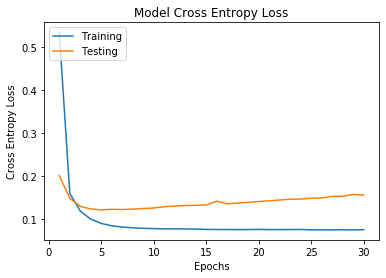

In [38]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['loss'])
sns.lineplot(x=range(1,num_epochs+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()

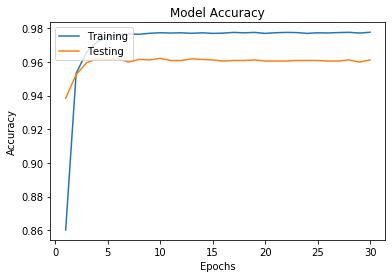

In [39]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['accuracy'])
sns.lineplot(x=range(1,num_epochs+1),y=r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Testing'], loc='upper left')
plt.show()

**Plotting the Confusion Matrix**

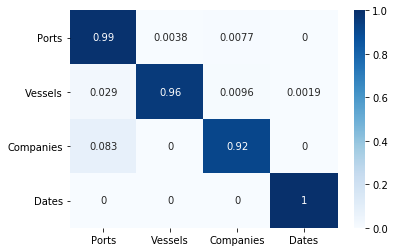

In [42]:
y_pred = model.predict(testing_padded).argmax(axis=1)
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=['Ports','Vessels','Companies','Dates'], yticklabels=['Ports','Vessels','Companies','Dates'], cmap='Blues')
ax.set_ylim(4.0, 0)
plt.show()

**Print Classification Report**

In [0]:
print(classification_report(y_true= y_test, y_pred = y_pred))

**Deep Learning (RNNs)**

Adding a bidirectional LSTM layer to see the impact on the model and cross validation scores

**Cross Validation with LSTM**

In [0]:
num_epochs = 10

In [110]:
scores = []
for train, test in kfold.split(padded, y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(padded[train], y_train[train], epochs=num_epochs, verbose=0)
  score = model.evaluate(padded[test], y_train[test], verbose=0)
  print("%s: %.2f%%" % ('Accuracy', score[1]*100))
  scores.append(score[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))

Accuracy: 96.25%
Accuracy: 96.32%
Accuracy: 96.66%
Accuracy: 95.72%
Accuracy: 96.49%
96.29% (+/- 0.32%)


**Predicting on Test Data**

In [104]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 5, 16)             40000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 5, 64)             12544     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                10368     
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_47 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)              

In [0]:
r = model.fit(padded, y_train, epochs=num_epochs,verbose=0,validation_data=(val_padded,y_val))

**Plotting Loss and Accuracy**

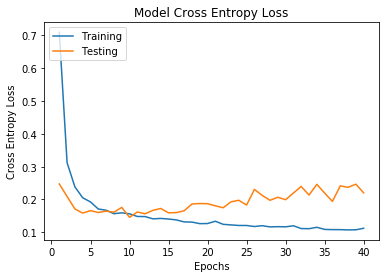

In [106]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['loss'])
sns.lineplot(x=range(1,num_epochs+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Testing'], loc='upper left')
plt.show()

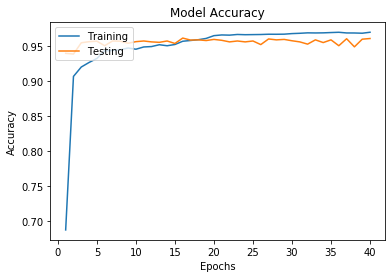

In [107]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['accuracy'])
sns.lineplot(x=range(1,num_epochs+1),y=r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()

**Plotting Confusion Matrix**

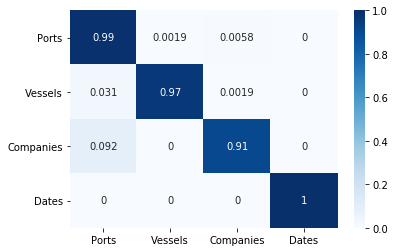

In [108]:
y_pred = model.predict(testing_padded).argmax(axis=1)
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=['Ports','Vessels','Companies','Dates'], yticklabels=['Ports','Vessels','Companies','Dates'], cmap='Blues')
ax.set_ylim(4.0, 0)
plt.show()

**Print Classification Report**

In [109]:
print(classification_report(y_true= y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       520
           1       1.00      0.97      0.98       520
           2       0.99      0.91      0.95       520
           3       1.00      1.00      1.00       520

    accuracy                           0.97      2080
   macro avg       0.97      0.97      0.97      2080
weighted avg       0.97      0.97      0.97      2080



**Deep Learning (CNNs)**

**Cross Validation**

In [0]:
num_epochs = 40

In [0]:
scores = []
for train, test in kfold.split(padded, y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(padded[train], y_train[train], epochs=num_epochs, verbose=0)
  score = model.evaluate(padded[test], y_train[test], verbose=0)
  print("%s: %.2f%%" % ('Accuracy', score[1]*100))
  scores.append(score[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))

**Predicting on Test Data**

In [98]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 5, 16)             40000     
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4, 64)             2112      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_15 (Dropout)         (None, 16)              

In [0]:
r = model.fit(padded, y_train, epochs=num_epochs,verbose=0,validation_data=(val_padded,y_val))

**Plotting Loss and Accuracy**

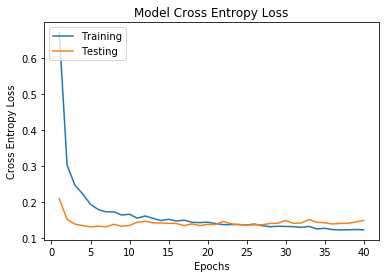

In [100]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['loss'])
sns.lineplot(x=range(1,num_epochs+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()

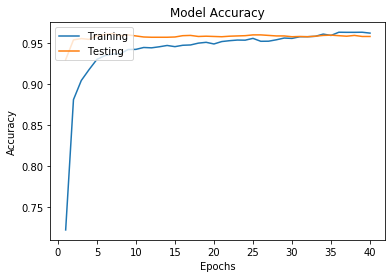

In [101]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['accuracy'])
sns.lineplot(x=range(1,num_epochs+1),y=r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()

**Plotting Confusion Matrix**

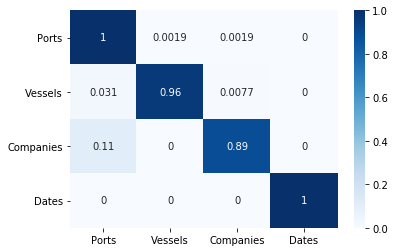

In [102]:
y_pred = model.predict(testing_padded).argmax(axis=1)
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=['Ports','Vessels','Companies','Dates'], yticklabels=['Ports','Vessels','Companies','Dates'], cmap='Blues')
ax.set_ylim(4.0, 0)
plt.show()

**Print Classification Report**

In [103]:
print(classification_report(y_true= y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       520
           1       1.00      0.96      0.98       520
           2       0.99      0.89      0.94       520
           3       1.00      1.00      1.00       520

    accuracy                           0.96      2080
   macro avg       0.97      0.96      0.96      2080
weighted avg       0.97      0.96      0.96      2080

